# NLP(RNN-LSTM) Model of Stock Sentiment from Twits

In [19]:
### Load Packages

import json
import nltk
import os
import random
import re
import torch
import json

from torch import nn, optim
import torch.nn.functional as F

## Introduction
When deciding the value of a company, it's important to follow the news. For example, a product recall or natural disaster in a company's product chain.

For this project,  i have used the posts from the social media site [StockTwits](https://en.wikipedia.org/wiki/StockTwits). The community on StockTwits is full of investors, traders, and entrepreneurs. Each message posted is called a Twit. This is similar to Twitter's version of a post, called a Tweet. I have build a NLP (RNN-LSTM) model around these twits that generate a sentiment score.

I have collected a  dataset consisting of collection of twits, which are labeled with the respective sentiments. To capture the degree of sentiment, we'll use a five-point scale: very negative, negative, neutral, positive, very positive. Each twit is labeled -2 to 2 in steps of 1, from very negative to very positive respectively. The NLP sentiment analysis model will learn to assign sentiment to twits on its own, using this labeled data.

Loading the data from Dataset.

## Import Twits 
### Load Twits Data 
This JSON file contains a list of objects for each twit in the `'data'` field:

```
{'data':
  {'message_body': 'Neutral twit body text here',
   'sentiment': 0},
  {'message_body': 'Happy twit body text here',
   'sentiment': 1},
   ...
}
```

The fields represent the following:

* `'message_body'`: The text of the twit.
* `'sentiment'`: Sentiment score for the twit, ranges from -2 to 2 in steps of 1, with 0 being neutral.


To see what the data look like by printing the first 10 twits from the list. 

In [11]:
with open("sentiments_twits.json", 'r') as f:
    twits = json.load(f)

#with open("sentiments_twits.json", 'w') as outfile:
#    json.dump(twits, outfile)
    
print("Twists Data Dictionary")    
print(twits['data'][:10])

Twists Data Dictionary
[{'message_body': '$FITB great buy at 26.00...ill wait', 'sentiment': 2, 'timestamp': '2018-07-01T00:00:09Z'}, {'message_body': '@StockTwits $MSFT', 'sentiment': 1, 'timestamp': '2018-07-01T00:00:42Z'}, {'message_body': '#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating', 'sentiment': 2, 'timestamp': '2018-07-01T00:01:24Z'}, {'message_body': '$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.', 'sentiment': 1, 'timestamp': '2018-07-01T00:01:47Z'}, {'message_body': '$AMD reveal yourself!', 'sentiment': 0, 'timestamp': '2018-07-01T00:02:13Z'}, {'message_body': '$AAPL Why the drop? I warren Buffet taking out his position?', 'sentiment': 1, 'timestamp': '2018-07-01T00:03:10Z'}, {'message_body': '$BA bears have 1 reason on 06-29 to pay more attention https://dividendbot.com?s=BA', 'sentiment': -2, 't

### Length of Data
Now let's look at the number of twits in dataset. Print the number of twits below.

In [12]:
"""print out the number of twits"""

# TODO Implement 

print(f"The number of twits is {len(twits['data'])}.")

The number of twits is 1548010.


### Split Message Body and Sentiment Score

In [13]:
messages = [twit['message_body'] for twit in twits['data']]
# Since the sentiment scores are discrete, we'll scale the sentiments to 0 to 4 for use in our network
sentiments = [twit['sentiment'] + 2 for twit in twits['data']]

print("Messages")
print(messages[:10])

print("Sentiments")
print(sentiments[:10])

Messages
['$FITB great buy at 26.00...ill wait', '@StockTwits $MSFT', '#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating', '$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.', '$AMD reveal yourself!', '$AAPL Why the drop? I warren Buffet taking out his position?', '$BA bears have 1 reason on 06-29 to pay more attention https://dividendbot.com?s=BA', '$BAC ok good we&#39;re not dropping in price over the weekend, lol', '$AMAT - Daily Chart, we need to get back to above 50.', '$GME 3% drop per week after spike... if no news in 3 months, back to 12s... if BO, then bingo... what is the odds?']
Sentiments
[4, 3, 4, 3, 2, 3, 0, 3, 4, 0]


## Preprocessing the Data
With our data in hand we need to preprocess our text. These twits are collected by filtering on ticker symbols where these are denoted with a leader $ symbol in the twit itself. For example,

`{'message_body': 'RT @google Our annual look at the year in Google blogging (and beyond) http://t.co/sptHOAh8 $GOOG',
 'sentiment': 0}`

The ticker symbols don't provide information on the sentiment, and they are in every twit, so we should remove them. This twit also has the `@google` username, again not providing sentiment information, so we should also remove it. We also see a URL `http://t.co/sptHOAh8`. Let's remove these too.


In [24]:
for msg in messages[:100]:
    print(msg)

$FITB great buy at 26.00...ill wait
@StockTwits $MSFT
#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating
$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.
$AMD reveal yourself!
$AAPL Why the drop? I warren Buffet taking out his position?
$BA bears have 1 reason on 06-29 to pay more attention https://dividendbot.com?s=BA
$BAC ok good we&#39;re not dropping in price over the weekend, lol
$AMAT - Daily Chart, we need to get back to above 50.
$GME 3% drop per week after spike... if no news in 3 months, back to 12s... if BO, then bingo... what is the odds?
$SBUX STRONG BUY!
$SNPS short ratio is 2.17 at 2018-06-15 and short % to float is 1.42% http://sunshineavenue.com/stock/SNPS/ via @sunshineave
$NFLX price squeezing,perfect place for an option straddle near the supporting trend
@DEEPAKM2013 @Nytunes Start of new Q on Mon

### Pre-Processing

In [25]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA T500', major=7, minor=5, total_memory=4095MB, multi_processor_count=14)

In [26]:
nltk.download('wordnet')

def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - tokenize by splitting the string on whitespace 
        - removes any single character tokens
    
    Parameters
    ----------
        message : The text message to be preprocessed.
        
    Returns
    -------
        tokens: The preprocessed text into tokens.
    """ 
    #TODO: Implement 
    URL_PATTERN = "https?:\/\/.*[\r\n]*"
    TICKER_PATTERN = r'\$[A-Za-z][\S]*'
    USERNAME_PATTERN = r'@[a-zA-Z0-9]*'
    NOT_LETTER_PATTERN = r'[^a-zA-Z]'
    
    # Lowercase the twit message
    text = message.lower()
    
    # Replace URLs with a space in the message
    text = re.sub(URL_PATTERN, " ", text)
    
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub(TICKER_PATTERN, " ", text)
    
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub(USERNAME_PATTERN, " ", text)

    # Replace everything not a letter with a space
    text = re.sub(NOT_LETTER_PATTERN, " ", text)
    
    # Tokenize by splitting the string on whitespace into a list of words
    tokens = text.split()

    # Lemmatize words using the WordNetLemmatizer. You can ignore any word that is not longer than one character.
    wnl = nltk.stem.WordNetLemmatizer()
    tokens = [ wnl.lemmatize(token) for token in tokens if len(token)>1]

    assert type(tokens) == list, 'Tokens should be list'
    return tokens

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\deepa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


>Note: You must ensure that after preprocessing the text should NOT include:
- Numbers
- URLs
- Single character tokens
- Ticker symbols (these should be removed even if they don't appear at the beginning)

### Preprocess All the Twits 
Now we can preprocess each of the twits in our dataset. Applying the function `preprocess` to all the twit messages.

In [27]:
for m in messages[:5]:
    print(f"original:{m}")
    print(f">>>>:{preprocess(m)}")
    print("-----------------------------------------")

original:$FITB great buy at 26.00...ill wait
>>>>:['great', 'buy', 'at', 'ill', 'wait']
-----------------------------------------
original:@StockTwits $MSFT
>>>>:[]
-----------------------------------------
original:#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating
>>>>:['staanalystalert', 'for', 'jefferies', 'maintains', 'with', 'rating', 'of', 'hold', 'setting', 'target', 'price', 'at', 'usd', 'our', 'own', 'verdict', 'is', 'buy']
-----------------------------------------
original:$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.
>>>>:['heard', 'there', 'guy', 'who', 'know', 'someone', 'who', 'think', 'somebody', 'know', 'something', 'on', 'stocktwits']
-----------------------------------------
original:$AMD reveal yourself!
>>>>:['reveal', 'yourself']
-----------------------------------------


In [28]:
# Tokenized_word
#tokenized_msg = [ preprocess(m) for m in messages]

In [29]:
import pickle
pickle.dump( tokenized_msg, open( "tokenized_msgs.p", "wb" ) )

In [30]:
# loading the tokenized messages file 
import pickle
tokenized_msg = pickle.load( open( "tokenized_msgs.p", "rb" ) )

In [31]:
tokenized_msg[:2]

[['great', 'buy', 'at', 'ill', 'wait'], []]

In [32]:
len(tokenized_msg)

1548010

### Bag of Words
Now with all of our messages tokenized, we want to create a vocabulary and count up how often each word appears in our entire corpus. 

In [33]:
from collections import Counter
"""
Create a vocabulary by using Bag of words
"""
# Counter and Tokenized message
bow = Counter()
# Update the vocab
for token in tokenized_msg:
    #print(token)
    bow.update(token)

In [35]:
bow

Counter({'great': 17514,
         'buy': 76019,
         'at': 138200,
         'ill': 881,
         'wait': 11356,
         'staanalystalert': 4072,
         'for': 272837,
         'jefferies': 1056,
         'maintains': 902,
         'with': 68688,
         'rating': 15423,
         'of': 210917,
         'hold': 22131,
         'setting': 3886,
         'target': 16419,
         'price': 37015,
         'usd': 2954,
         'our': 12187,
         'own': 8954,
         'verdict': 3736,
         'is': 283863,
         'heard': 1352,
         'there': 25578,
         'guy': 13406,
         'who': 17836,
         'know': 19901,
         'someone': 5186,
         'think': 24241,
         'somebody': 1099,
         'something': 5996,
         'on': 241385,
         'stocktwits': 1437,
         'reveal': 195,
         'yourself': 1203,
         'why': 21628,
         'the': 397886,
         'drop': 17771,
         'warren': 1013,
         'buffet': 1298,
         'taking': 6406,
       

In [36]:
len(bow.keys())

98300

### Frequency of Words Appearing in Message
With our vocabulary, now we'll remove some of the most common words such as 'the', 'and', 'it', etc. These words don't contribute to identifying sentiment and are really common, resulting in a lot of noise in our input. If we can filter these out, then our network should have an easier time learning.

We also want to remove really rare words that show up in a only a few twits. Here you'll want to divide the count of each word by the **number of messages** calculated in the code block above (i.e. `len(messages))`. Then remove words that only appear in some small fraction of the messages.

>Note: There is not an exact number for low and high-frequency cut-offs, however there is a correct optimal range.
You should ideally set up low-frequency cut-off from 0.0000002 to 0.000007 (inclusive) and high-frequency from 5 to 20 (inclusive). If the number is too big, we lose lots of important words that we can use in our data.

In [37]:
len(messages)

1548010

In [38]:
no_messages = len(messages)

In [39]:
freqs = { w:c/no_messages for w, c in bow.items()}

In [40]:
freqs

{'great': 0.011313880401289398,
 'buy': 0.04910756390462594,
 'at': 0.08927590907035485,
 'ill': 0.0005691177705570377,
 'wait': 0.0073358699233209085,
 'staanalystalert': 0.00263047396334649,
 'for': 0.1762501534227815,
 'jefferies': 0.0006821661358776752,
 'maintains': 0.0005826835743955142,
 'with': 0.04437180638367969,
 'rating': 0.009963113933372524,
 'of': 0.1362504118190451,
 'hold': 0.0142964192737773,
 'setting': 0.002510319700777127,
 'target': 0.010606520629711694,
 'price': 0.02391134424196226,
 'usd': 0.0019082564066123604,
 'our': 0.007872688160929193,
 'own': 0.005784200360462788,
 'verdict': 0.002413421101930866,
 'is': 0.18337284642864063,
 'heard': 0.0008733793709342963,
 'there': 0.016523149075264372,
 'guy': 0.008660150774219805,
 'who': 0.011521889393479371,
 'know': 0.012855860104262892,
 'someone': 0.0033501075574447195,
 'think': 0.0156594595642147,
 'somebody': 0.0007099437342136033,
 'something': 0.003873359991214527,
 'on': 0.15593245521669757,
 'stocktwits':

In [41]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (30,10)

In [42]:
import numpy as np

([<matplotlib.axis.YTick at 0x26d95fe5250>], [Text(0, 1, 'Token')])

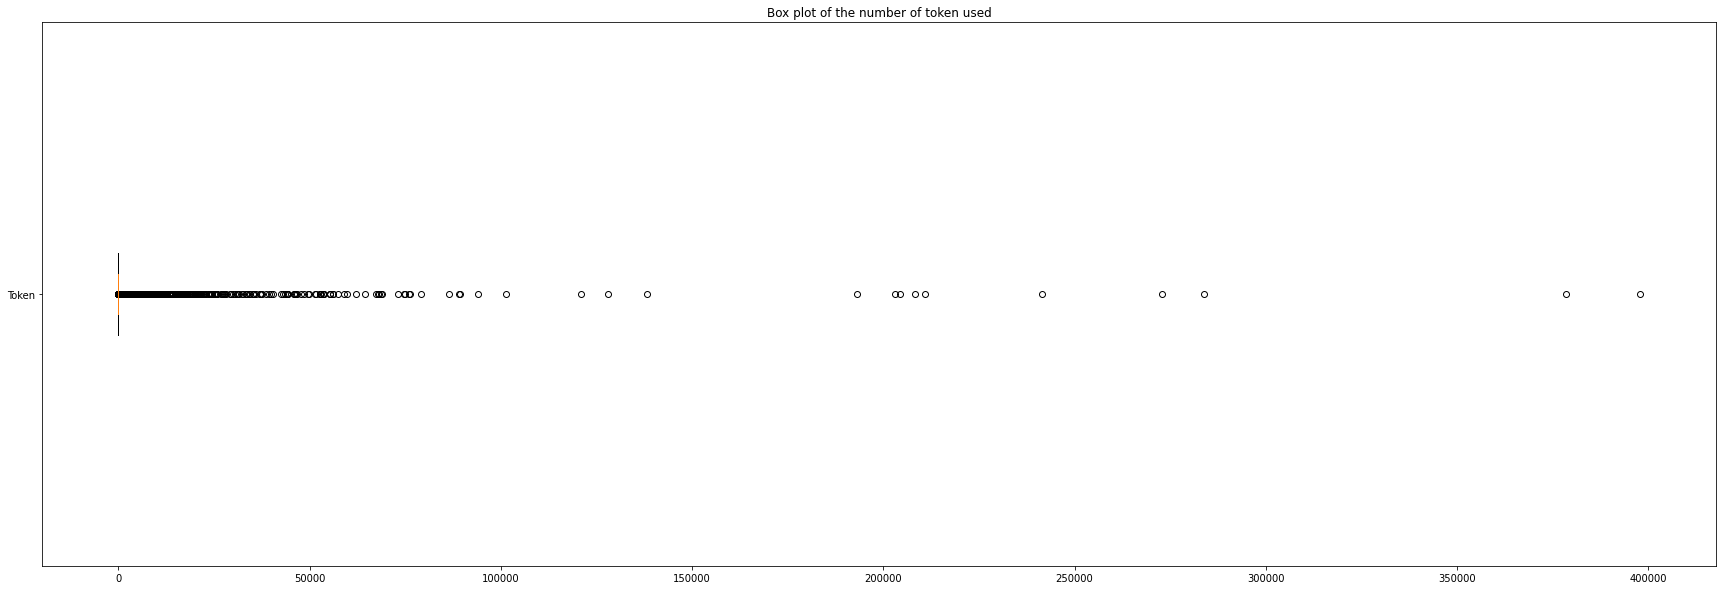

In [43]:
plt.boxplot(bow.values(),notch=1,vert=False,)
plt.title("Box plot of the number of token used")
plt.yticks([1], ['Token'])

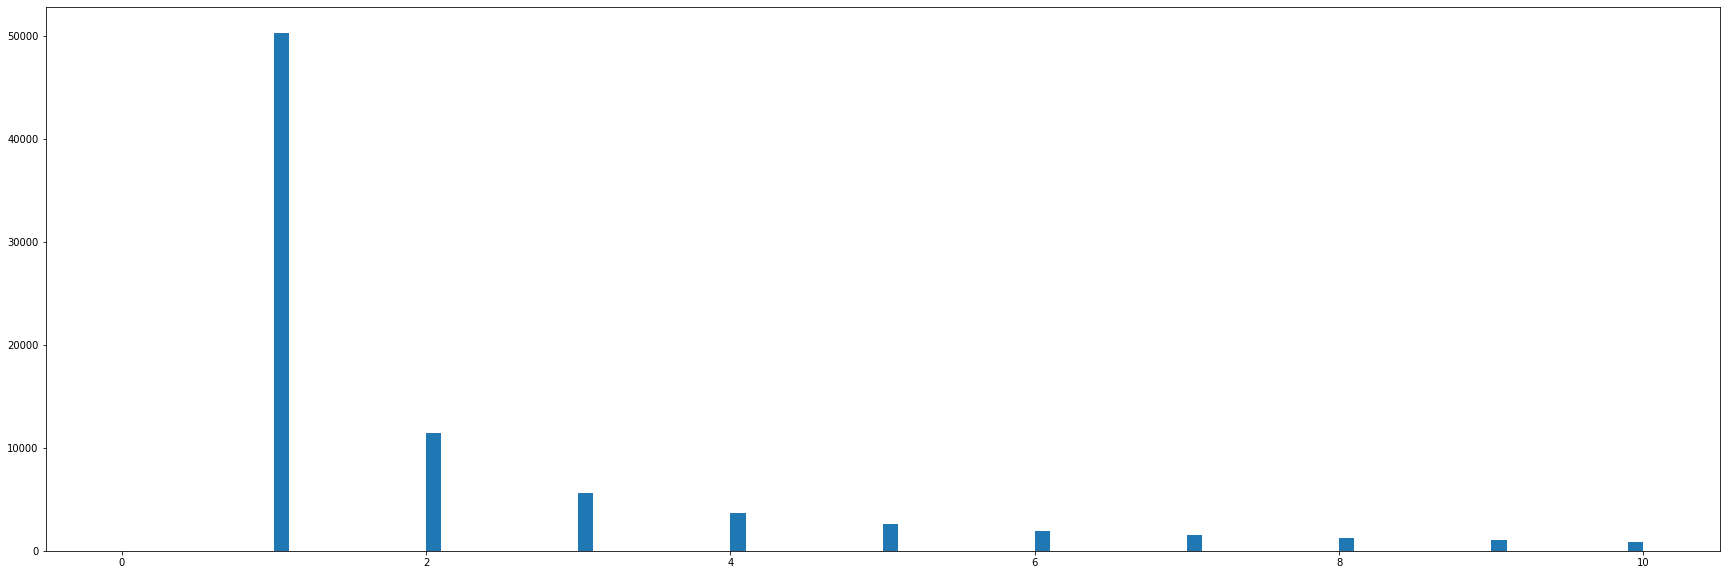

In [44]:
rge = plt.hist(bow.values(), bins=100, range=(0, 10))

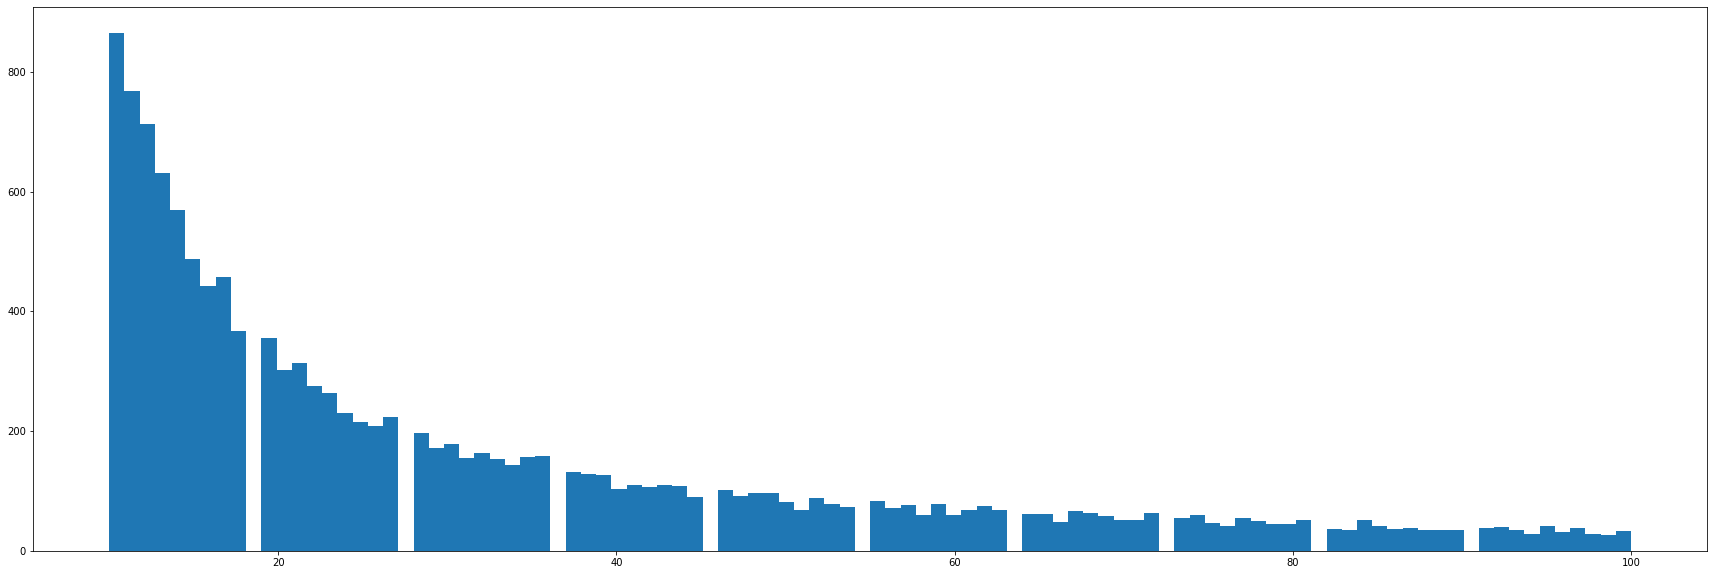

In [45]:
rge = plt.hist(bow.values(), bins=100, range=(10, 100))

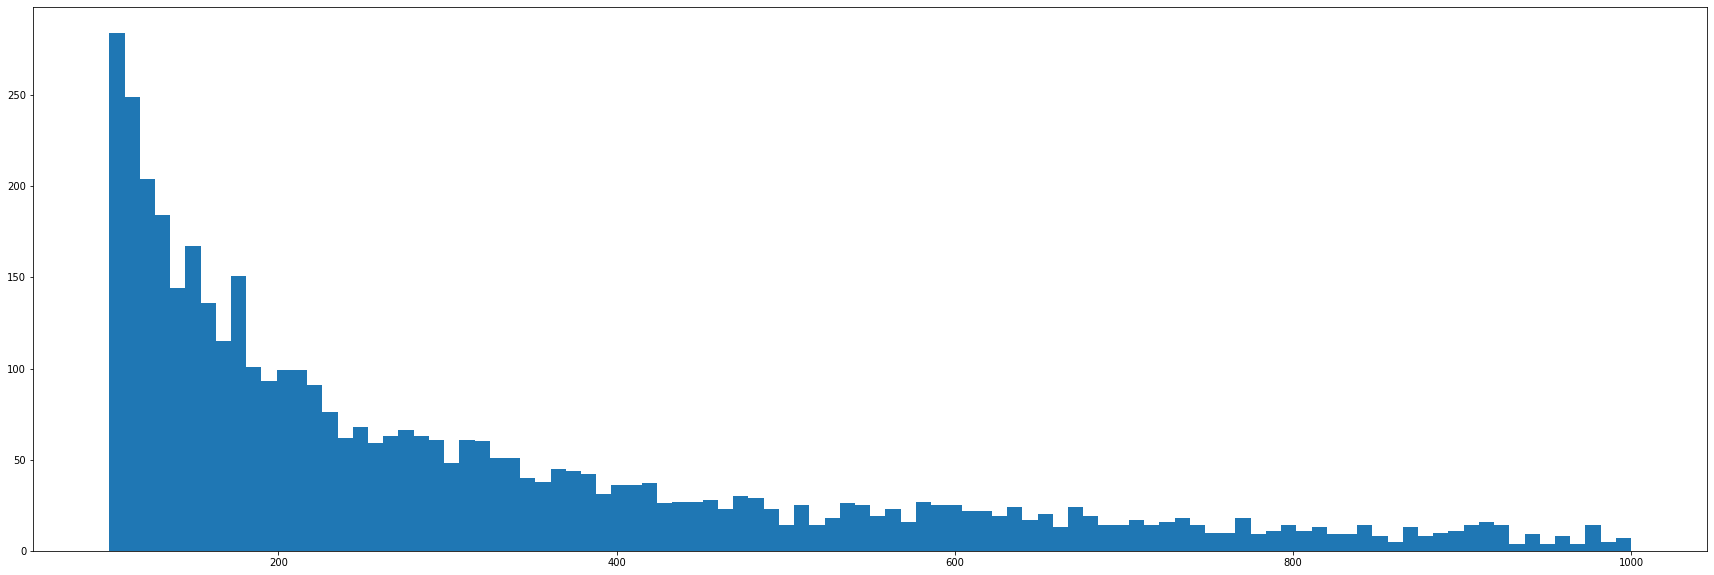

In [46]:
rge = plt.hist(bow.values(), bins=100, range=(100, 1000))

In [47]:
# Based on the histogram of the distribution
# we select low and high threshold.
low = 50
high = 100000
selected_bow = { w:c for w, c in bow.items() if low<= c <=high}

print("Selected Bag of words from Lower to High Threshold")
#print(selected_bow)

Selected Bag of words from Lower to High Threshold


In [48]:
# Sorting the selected words
sorted_word = [k for k, v in sorted(selected_bow.items(), key=lambda kv:kv[1])]
print(sorted_word[:10])

['employed', 'flowserve', 'studying', 'intent', 'wto', 'rethink', 'appetite', 'occurring', 'believable', 'mk']


([<matplotlib.axis.YTick at 0x26d96f9fee0>], [Text(0, 1, 'Token')])

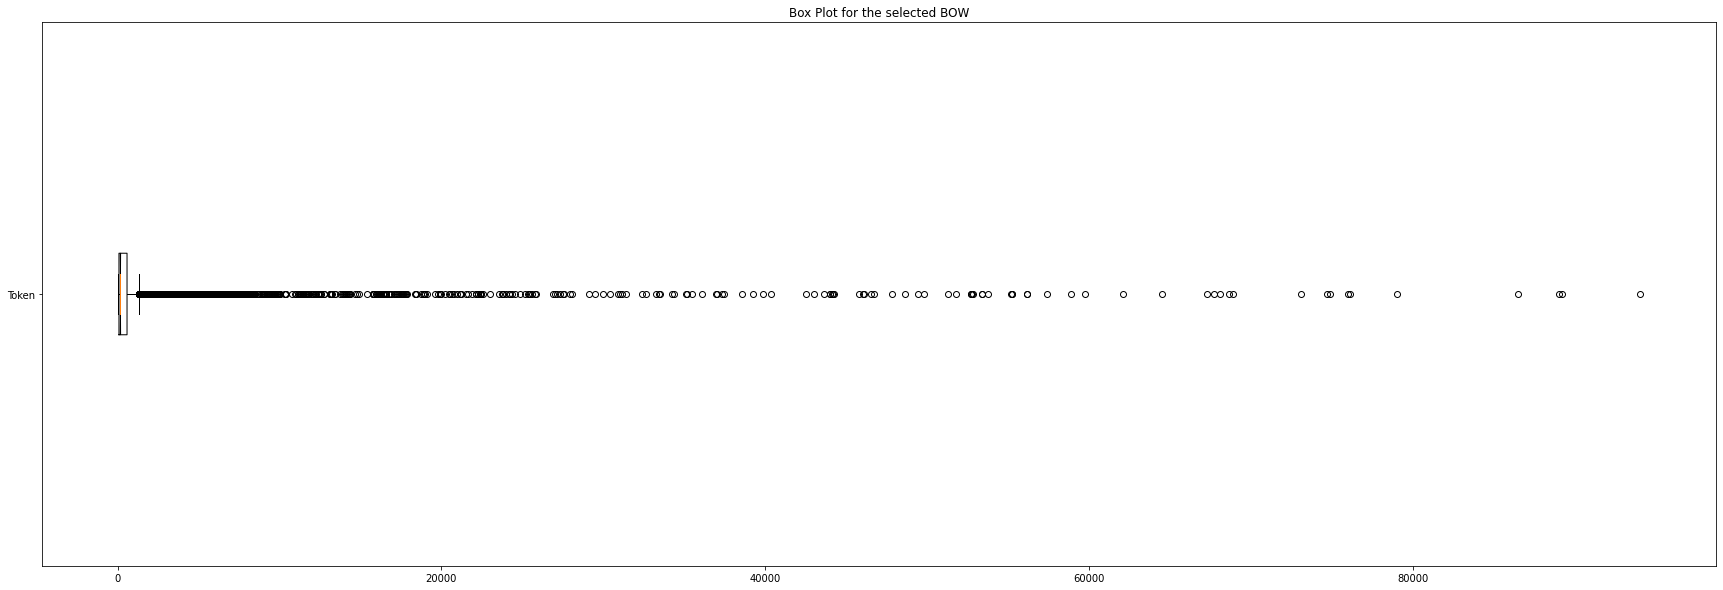

In [49]:
#Box-Plot for the selected bag of words distribution
Boxplot_selected_bow = plt.boxplot(selected_bow.values(), notch=1, vert=False,)
plt.title("Box Plot for the selected BOW")
plt.yticks([1], ['Token'])

In [50]:
print("The number of selected token between low:{} and high:{} threshold".format(low,high))
print(len(selected_bow))

# Percent of words in the threshold
percent_words = len(selected_bow)*100/len(bow)
print(percent_words)

The number of selected token between low:50 and high:100000 threshold
8418
8.563580874872839


In [51]:
# Removing Stopwords from the Vocabulary.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
english_stopword = set(stopwords.words('english'))
print(english_stopword)

{'when', 'shouldn', 'itself', 've', 'wasn', "you'd", 'isn', 'if', 'been', 'just', 'does', 'between', 'few', 'being', "hadn't", "didn't", 'them', 'myself', 'further', 'more', 'had', 'at', 'to', 'they', "haven't", 'couldn', 'doesn', 'himself', 'having', 'off', "mightn't", 'but', 'while', 'what', "don't", 'an', 'any', 'not', 'is', 'so', "weren't", 'themselves', 'own', "you're", 'against', 'm', 'these', 'on', 'and', 'same', 'o', 'have', 'those', "aren't", 'for', 'too', 'he', "you've", 'some', 'am', 'we', 'ours', 'who', "that'll", 'out', 'll', 'y', 'weren', 'until', 'won', 'whom', 'after', 'hers', 'their', 'such', 'can', 'then', 'mustn', 'no', 'during', 'with', 'herself', "you'll", "doesn't", 'haven', 'by', 'his', 're', 'before', 'yours', 'below', 'mightn', 'again', "hasn't", "shouldn't", 'do', 'it', 'under', 'nor', 'ma', 'into', 'about', 'once', 'both', 'in', 'she', 'shan', 'this', 'theirs', 'd', 'are', "she's", 'from', 'i', 'over', 'will', "isn't", 'above', "it's", 'as', 'were', 'aren', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deepa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
"""
Set the following variables:
    freqs
    low_cutoff
    high_cutoff
    K_most_common
"""
low = 50

total = len(tokenized_msg)
# Dictionart that contains the Frequency of words appearing in messages.
# The key is the token and the value is the frequency of that word in the corpus.
freqs = { w:c/no_messages for w, c in bow.items()}
#print(freqs)
# Float that is the frequency cutoff. Drop words with a frequency that is lower or equal to this number.
low_cutoff = low/total
print(low_cutoff)

# Integer that is the cut off for most common words. Drop words that are the `high_cutoff` most common words.
high_cutoff = 20

# The k most common words in the corpus. Use `high_cutoff` as the k.
K_most_common = [ w for w, f, in bow.most_common(high_cutoff)]

# Filtered Words
filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]
#print(K_most_common)
len(filtered_words)
print(filtered_words[:10])

3.229953294875356e-05
['great', 'buy', 'ill', 'wait', 'staanalystalert', 'jefferies', 'maintains', 'with', 'rating', 'hold']


In [53]:
len(filtered_words)

8331

In [54]:
filter_words = [ word for word in filtered_words if word not in (english_stopword)]

In [55]:
len(filter_words)

8210

### Updating Vocabulary by Removing Filtered Words
Let's creat three variables that will help with our vocabulary.

In [56]:
"""
Set the following variables:
    vocab
    id2vocab
    filtered
"""
# A dictionary for the `filtered_words`. The key is the word and value is an id that represents the word. 
vocab = { v:i for i, v in enumerate(filter_words)}
print(len(vocab))

8210


In [57]:
# Reverse of the `vocab` dictionary. The key is word id and value is the word. 
id2vocab = {i:v for v, i in vocab.items()}
#print(id2vocab)

In [58]:
# tokenized with the words not in `filtered_words` removed.
filtered_msgs = [[word for word in message if word in vocab] for message in tokenized_msg]

In [59]:
filtered_msgs[:5]

[['great', 'buy', 'ill', 'wait'],
 [],
 ['staanalystalert',
  'jefferies',
  'maintains',
  'rating',
  'hold',
  'setting',
  'target',
  'price',
  'usd',
  'verdict',
  'buy'],
 ['heard',
  'guy',
  'know',
  'someone',
  'think',
  'somebody',
  'know',
  'something',
  'stocktwits'],
 ['reveal']]

### Balancing the classes
If we look at how our twits are labeled, we'll find that 50% of them are neutral. This means that our network will be 50% accurate just by guessing 0 every single time. To help our network learn appropriately, we'll want to balance our classes.
That is, make sure each of our different sentiment scores show up roughly as frequently in the data.

What we can do here is go through each of our examples and randomly drop twits with neutral sentiment. What should be the probability we drop these twits if we want to get around 20% neutral twits starting at 50% neutral? We should also take this opportunity to remove messages with length 0.

In [60]:
# sentiments have been rescaled to 0-4 from -2 to 2
set(sentiments)

{0, 1, 2, 3, 4}

In [61]:
balanced = {'messages': [], 'sentiments':[]}
# 2 is the neutral sentiments.
num_neutral = sum(1 for each in sentiments if each == 2)
print("Neutral sentiment")
print(num_neutral)
num_total = len(sentiments)
print("Total sentiment")
print(num_total)
diff = (num_total - num_neutral)
print("Difference")
print(diff)
# Probablity of Neutral sentiments out of Total sentiments.
keep_prob = num_neutral/num_total
print(keep_prob)
print("Percentage Neutral Emotions")
print(keep_prob*100)

Neutral sentiment
701597
Total sentiment
1548010
Difference
846413
0.453225108364933
Percentage Neutral Emotions
45.3225108364933


In [62]:
#print(random.random())
for index, sentiment in enumerate(sentiments[:5]):
    print(index)
    message = filtered_msgs[index]
    print(message)
    print(len(message))
    # Randomly drop twits for probablity less than 30%.
    if sentiment != 2 or random.random() < keep_prob:
        print(message)
        print(sentiment) 

0
['great', 'buy', 'ill', 'wait']
4
['great', 'buy', 'ill', 'wait']
4
1
[]
0
[]
3
2
['staanalystalert', 'jefferies', 'maintains', 'rating', 'hold', 'setting', 'target', 'price', 'usd', 'verdict', 'buy']
11
['staanalystalert', 'jefferies', 'maintains', 'rating', 'hold', 'setting', 'target', 'price', 'usd', 'verdict', 'buy']
4
3
['heard', 'guy', 'know', 'someone', 'think', 'somebody', 'know', 'something', 'stocktwits']
9
['heard', 'guy', 'know', 'someone', 'think', 'somebody', 'know', 'something', 'stocktwits']
3
4
['reveal']
1


In [63]:
for i, sentiment in enumerate(sentiments):
    message = filtered_msgs[i]
    if len(message) == 0:
        # skip this message because it has length zero
        continue
    
    elif sentiment != 2 or random.random() < keep_prob:
        balanced['messages'].append(message)
        balanced['sentiments'].append(sentiment)

Finally let's convert our tokens into integer ids which we can pass to the network.

In [45]:
n_neutral = sum(1 for each in balanced['sentiments'] if each == 2)
N_examples = len(balanced['sentiments'])
n_neutral/N_examples

0.2661718025624299

In [46]:
token_ids = [[vocab[word] for word in message] for message in balanced['messages']]
sentiments = balanced['sentiments']

In [47]:
token_ids[:5]

[[0, 1, 2, 3],
 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1],
 [14, 15, 16, 17, 18, 19, 16, 20, 21],
 [23, 24, 25, 26, 27],
 [28, 29, 30, 31]]

In [48]:
sentiments[:5]

[4, 4, 3, 3, 0]

In [49]:
vocab

{'great': 0,
 'buy': 1,
 'ill': 2,
 'wait': 3,
 'staanalystalert': 4,
 'jefferies': 5,
 'maintains': 6,
 'rating': 7,
 'hold': 8,
 'setting': 9,
 'target': 10,
 'price': 11,
 'usd': 12,
 'verdict': 13,
 'heard': 14,
 'guy': 15,
 'know': 16,
 'someone': 17,
 'think': 18,
 'somebody': 19,
 'something': 20,
 'stocktwits': 21,
 'reveal': 22,
 'drop': 23,
 'warren': 24,
 'buffet': 25,
 'taking': 26,
 'position': 27,
 'bear': 28,
 'reason': 29,
 'pay': 30,
 'attention': 31,
 'ok': 32,
 'good': 33,
 'dropping': 34,
 'weekend': 35,
 'lol': 36,
 'daily': 37,
 'chart': 38,
 'need': 39,
 'get': 40,
 'back': 41,
 'per': 42,
 'week': 43,
 'spike': 44,
 'news': 45,
 'month': 46,
 'bo': 47,
 'bingo': 48,
 'odds': 49,
 'strong': 50,
 'ratio': 51,
 'float': 52,
 'squeezing': 53,
 'perfect': 54,
 'place': 55,
 'option': 56,
 'straddle': 57,
 'near': 58,
 'supporting': 59,
 'trend': 60,
 'start': 61,
 'new': 62,
 'monday': 63,
 'expect': 64,
 'volume': 65,
 'across': 66,
 'key': 67,
 'company': 68,
 'var

In [50]:
len(vocab)

8210

In [51]:
len(token_ids)

1120577

In [52]:
len(sentiments)

1120577

## (RNN-LSTM) Neural Network
Now we have our vocabulary which means we can transform our tokens into ids, 
which are then passed to our network. 

The Neural Network will have the following architecture:- 

#### Embed -> RNN -> Dense -> Softmax

The network called "TextClassifer" - consists of three main parts: 
1) init function `__init__` 
2) forward pass `forward`  
3) hidden state `init_hidden`. 

In [64]:
torch.__version__

'1.11.0'

In [65]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
    print(train_on_gpu)
else:
    print('No GPU available, training on CPU.')

Training on GPU.
True


In [66]:
import torch.nn as nn

class TextClassifier(nn.Module):
    """
        The RNN model that will be used for perform Sentiment Analysis.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.3):
        """
        The RNN model that will be used for perform Sentiment Analysis.
        """
        super(TextClassifier, self).__init__()
        
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # setting embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # Fully Connected Layer and Softmax
        self.fc = nn.Linear(hidden_dim, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)
        

    def init_hidden(self, batch_size):
        """ 
        Initializes hidden state    
        """
        
        # TODO Implement 
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        

        return hidden


    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        
        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        # stack up lstm outputs
        #lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        lstm_out = lstm_out.contiguous()[:,-1,:]
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # log_softmax on the output.
        log_softmax = self.log_softmax(out)
        
        # return log_softmax, hidden layers.
        return log_softmax, hidden

### View Model

In [67]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab)+1 # +1 for the 0 padding + our word tokens
output_size = 5
embedding_dim = 1024
hidden_dim = 512
n_layers = 2

net = TextClassifier(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

net.embedding.weight.data.uniform_(-1, 1)

TextClassifier(
  (embedding): Embedding(8211, 1024)
  (lstm): LSTM(1024, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=5, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


tensor([[-0.5220, -0.5295,  0.8280,  ...,  0.0615,  0.4466, -0.4929],
        [-0.5306,  0.4750,  0.8708,  ..., -0.6177,  0.1882, -0.0696],
        [-0.0495, -0.0133, -0.6931,  ..., -0.8097, -0.7502,  0.5648],
        ...,
        [ 0.8481, -0.1492, -0.9689,  ...,  0.1076,  0.2655,  0.7090],
        [ 0.5374, -0.7855,  0.0158,  ..., -0.3262, -0.9101, -0.4982],
        [ 0.5830,  0.7805, -0.7305,  ...,  0.8137, -0.2383, -0.3278]])

In [68]:
# Instantiate the model w/ hyperparams
input1 = torch.randint(0, 1000, (5, 4), dtype=torch.int64)
print(input1)
hidden1 = net.init_hidden(5)
print(hidden1)
input1=input1.cuda()
net = net.cuda()
logps, _ = net.forward(input1, hidden1)
print(logps)

del input1

tensor([[760, 936, 828, 960],
        [700, 588, 443,   2],
        [155, 539, 306, 838],
        [692, 305, 893, 713],
        [619, 987,   2,  27]])
(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'), tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], de

In [58]:
def pad_features(reviews_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
  
    # getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    # for each review, I grab that review and 
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [59]:
seq_length = 40

features = pad_features(token_ids, seq_length=seq_length)

## test statements - do not change - ##
assert len(features)==len(token_ids), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

# print first 10 values of the first 30 batches 
print(features[-10:,-10:])

[[   0    0    0    0 3134 1758  368  711 4132   56]
 [   0    0    0    0    0   84  126  548 1038  126]
 [   0    0   88 1089  431 4834 7688  785  176   56]
 [   0    0    0    0    0    0 3984  169 6610 4067]
 [   0    0    0    0    0    0    0    0    0   84]
 [3099  873 1368 5686 1890   85 5693  826 2256  940]
 [   0    0    0    0    0    0 1254 1131 2860 3623]
 [   0    0    0    0    0    0    0   65  580  581]
 [   0    0    0    0    0    0    0    0    0 1083]
 [   0    0    0    0    0    0   11   10   40  304]]


In [60]:
print(len(features))
print(len(sentiments))

1120577
1120577


In [61]:
sentiments_labels = np.array(sentiments)
sentiments_labels

array([4, 4, 3, ..., 0, 4, 4])

## Training
### DataLoaders and Batching
Now we should build a generator that we can use to loop through our data. It'll be more efficient if we can pass our sequences in as batches. Our input tensors should look like `(sequence_length, batch_size)`. So if our sequences are 40 tokens long and we pass in 25 sequences, then we'd have an input size of `(40, 25)`.

If we set our sequence length to 40, what do we do with messages that are more or less than 40 tokens? For messages with fewer than 40 tokens, we will pad the empty spots with zeros. We should be sure to **left** pad so that the RNN starts from nothing before going through the data. If the message has 20 tokens, then the first 20 spots of our 40 long sequence will be 0. If a message has more than 40 tokens, we'll just keep the first 40 tokens.

In [62]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)
split_idx = int(len(features)*0.8)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = sentiments_labels[:split_idx], sentiments_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(896461, 40) 
Validation set: 	(112058, 40) 
Test set: 		(112058, 40)


In [63]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 1024

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [64]:
# obtain one batch of training data
dataiter = iter(valid_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([1024, 40])
Sample input: 
 tensor([[    0,     0,     0,  ...,  1701,   368,   148],
        [    0,     0,     0,  ...,    41,  1001,   493],
        [    0,     0,     0,  ...,  2038,  1829,  6348],
        ...,
        [    0,     0,     0,  ...,  1153,   548,  1214],
        [    0,     0,     0,  ...,    18,   633,  1001],
        [    0,     0,     0,  ...,   341,    45,   748]])

Sample label size:  torch.Size([1024])
Sample label: 
 tensor([ 1,  4,  0,  ...,  3,  1,  2])


In [65]:
torch.cuda.is_available()

True

In [66]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


### Training and  Validation
With our data in nice shape, we'll split it into training and validation sets.

In [67]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab)+1 # +1 for the 0 padding + our word tokens
output_size = 5
embedding_dim = 2048
hidden_dim = 1024
n_layers = 2

net = TextClassifier(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

TextClassifier(
  (embedding): Embedding(8211, 2048)
  (lstm): LSTM(2048, 1024, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=1024, out_features=5, bias=True)
  (log_softmax): LogSoftmax()
)


In [68]:
import os
import torch
import gc

gc.collect()

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

torch.cuda.empty_cache()

#print(torch.cuda.memory_summary(device=None, abbreviated=False))

# loss and optimization functions
lr=0.001

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# training params
epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs

train_losses = []
valid_losses = []
valid_accuracies = []
best_val_accuracy=0

for e in range(epochs):
    
    train_loss=0
    
    # initialize hidden state
    h = net.init_hidden(batch_size)
    
    # batch loop
    for inputs, labels in train_loader:
        counter += 1
        labels = labels.type(torch.LongTensor)
        
        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)
        
        loss = criterion(output, labels)
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        
        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                labels = labels.type(torch.LongTensor)
                
                val_h = tuple([each.data for each in val_h])
                
                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()
                    
                output, val_h = net(inputs, val_h)
                # Accuracy
                probs = torch.exp(output)
                top_prob, top_class = probs.topk(1)
                equality = top_class == labels.view(*top_class.shape)
                valid_accuracy = torch.mean(equality.type(torch.FloatTensor))                                             
                valid_loss = criterion(output, labels)
                                            
            train_losses.append(loss.item())
            valid_losses.append(valid_loss.item())
            valid_accuracies.append(valid_accuracy.item())
            
            net.train()
            current_val_accuracy=sum(valid_accuracies)/len(valid_accuracies)
                                            
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Train Loss: {:.6f}...".format(loss.item()),
                  "Validation Loss: {:.6f}".format(np.mean(valid_losses)),
                  "Valid Accuracies: {:.6f}".format(valid_accuracy.item()))
            
            if current_val_accuracy > best_val_accuracy:
                
                torch.save(net,'sentiment_rnn_model.pth')
                best_val_accuracy=current_val_accuracy
                print("New best accuracy model is saved")

Epoch: 1/4... Step: 100... Train Loss: 0.946518... Validation Loss: 0.923123 Valid Accuracies: 0.640625


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type TextClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


New best accuracy model is saved
Epoch: 1/4... Step: 200... Train Loss: 0.939443... Validation Loss: 0.913583 Valid Accuracies: 0.668945
New best accuracy model is saved
Epoch: 1/4... Step: 300... Train Loss: 0.886091... Validation Loss: 0.908110 Valid Accuracies: 0.660156
New best accuracy model is saved
Epoch: 1/4... Step: 400... Train Loss: 0.930644... Validation Loss: 0.904888 Valid Accuracies: 0.643555
Epoch: 1/4... Step: 500... Train Loss: 0.851626... Validation Loss: 0.903782 Valid Accuracies: 0.666016
Epoch: 1/4... Step: 600... Train Loss: 0.854830... Validation Loss: 0.894628 Valid Accuracies: 0.670898
New best accuracy model is saved
Epoch: 1/4... Step: 700... Train Loss: 0.861784... Validation Loss: 0.894041 Valid Accuracies: 0.653320
Epoch: 1/4... Step: 800... Train Loss: 0.847383... Validation Loss: 0.886110 Valid Accuracies: 0.657227
Epoch: 2/4... Step: 900... Train Loss: 0.801743... Validation Loss: 0.880484 Valid Accuracies: 0.661133
Epoch: 2/4... Step: 1000... Train Lo

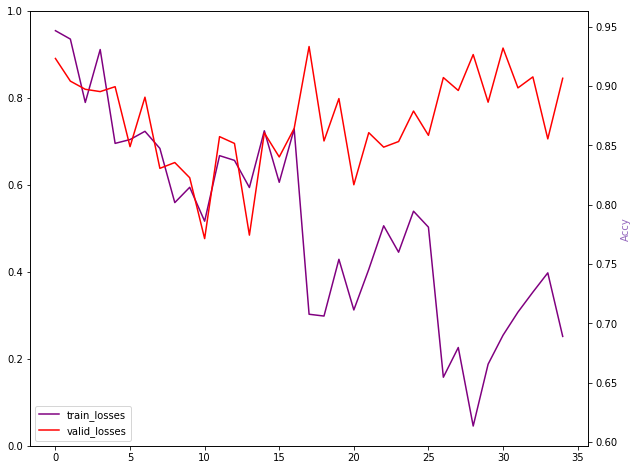

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(111)


ax2 = ax1.twinx()
ax2.set_ylabel('Accy', color='tab:purple')
ax2.plot(train_losses, label='train_losses', c='purple')
ax2.plot(valid_losses, label='valid_losses', c='red')

plt.legend()

In [104]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:
    
    labels = labels.type(torch.LongTensor)
    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output, labels)
    test_losses.append(test_loss.item())
    
    # Get the value of the logsoftmax value
    pred = torch.exp(output)  
    #print("Prediction of the model.")
    #print(pred)
    #print("Prediction Shape")
    #print(pred.shape)
    #print("Get the maximum value for each batch value")
    batch_pred = pred.view(batch_size,-1).argmax(1) 
    #print(batch_pred)
    #print("Prediction Shape after the transformation")
    #print(batch_pred.shape)
    #print("The test model result.")
    #print(labels)
    #print("labels Shape")
    #print(labels.shape)
    # compare predictions to true label
    correct_tensor = torch.eq(batch_pred,labels)
    #print(correct_tensor)
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    #print(correct)
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))
print(num_correct)
# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.976
71474.0
Test accuracy: 0.638


In [105]:
from string import punctuation

def tokenize_review(test_review):
    
    tokens = preprocess(test_review)
    
    # Filter non-vocab words
    tokens = [ token for token in tokens if token in vocab]
    # Convert words to ids
    tokens = [ vocab[token] for token in tokens]
           
    # tokens
    test_ints = []
    test_ints.append(tokens)

    return test_ints

## Making Predictions
### Prediction 
The trained model is applied on some new twits and see if it works appropriately.

In [106]:
def predict(net, test_review, sequence_length=40):
    ''' Prints out whether a give review is predicted to be 
        positive or negative in sentiment, using a trained model.
        
        params:
        net - A trained net 
        test_review - a review made of normal text and punctuation
        sequence_length - the padded length of a review
        '''
    net.eval()
    
    # tokenize review
    test_ints = tokenize_review(test_review)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.LongTensor(features)
    print("Feature Tensor")
    print(feature_tensor)
    
    batch_size = feature_tensor.size(0)
    print("Batch Size")
    print(batch_size)
    
    # initialize hidden state
    h = net.init_hidden(batch_size)
    
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    # get the output from the model
    logps,_ = net(feature_tensor, h)
    
    print("Model Output LogSoftmax result.")
    print(logps)
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.exp(logps) 
    # printing output value, before rounding
    print("Prediction Vector")
    print(pred)
    print("Maximum sentiment prediction value")
    print(torch.max(pred))
    print("Sentiment Score for each twit:-")
    sentiment_score = pred.argmax(1).item()
    print(sentiment_score)
    
    return sentiment_score

In [107]:
text = "Google is working on self driving cars, I'm bullish on $goog"
# test code and generate tokenized review
test_ints = tokenize_review(text)
print(test_ints)
print(predict(net, text))

[[231, 2171, 5693, 826, 2066, 109]]
Feature Tensor
tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,   231,  2171,
          5693,   826,  2066,   109]])
Batch Size
1
Model Output LogSoftmax result.
tensor([[-7.4066, -4.3293, -4.6386, -0.4070, -1.1683]], device='cuda:0')
Prediction Vector
tensor([[ 0.0006,  0.0132,  0.0097,  0.6656,  0.3109]], device='cuda:0')
Maximum sentiment prediction value
tensor(0.6656, device='cuda:0')
Sentiment Score for each twit:-
3
3


In [108]:
# test sequence padding
seq_length=40
features = pad_features(test_ints, seq_length)

print(features)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0  231 2171 5693  826 2066  109]]


Now we have a trained model and we can make predictions. We can use this model to track the sentiments of various stocks by predicting the sentiments of twits as they are coming in. Now we have a stream of twits. For each of those twits, pull out the stocks mentioned in them and keep track of the sentiments. Remember that in the twits, ticker symbols are encoded with a dollar sign as the first character, all caps, and 2-4 letters, like $AAPL.

## Testing
### Load the Data 

In [69]:
import os
import json

with open('test_twits.json', 'r') as f:
     test_data = json.load(f)

#json_object = json.dumps(test_data, indent = 4)        
        
#with open("test_twits.json", "w") as f1:
#     f1.write(json_object)        

### Twit Stream

In [110]:
def twit_stream():
    for twit in test_data['data']:
        yield twit

next(twit_stream())

{'message_body': '$JWN has moved -1.69% on 10-31. Check out the movement and peers at  https://dividendbot.com?s=JWN',
 'timestamp': '2018-11-01T00:00:05Z'}

Using the `prediction` function, let's apply it to a stream of twits.

In [111]:
def score_twits(stream, model, vocab, universe):
    """ 
    Given a stream of twits and a universe of tickers, return sentiment scores for tickers in the universe.
    """
    for twit in stream:

        # Get the message text
        twt_msg = twit['message_body']
        print(twt_msg)
        symbols = re.findall('\$[A-Z]{2,4}', twt_msg)
        score = predict(net,twt_msg)

        for symbol in symbols:
            if symbol in universe:
                yield {'symbol': symbol, 'score': score, 'timestamp': twit['timestamp']}

In [112]:
universe = {'$BBRY', '$AAPL', '$AMZN', '$BABA', '$YHOO', '$LQMT', '$FB', '$GOOG', '$BBBY', '$JNUG', '$SBUX', '$MU'}
score_stream = score_twits(twit_stream(), net, vocab, universe)

next(score_stream)

$JWN has moved -1.69% on 10-31. Check out the movement and peers at  https://dividendbot.com?s=JWN
Feature Tensor
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  88,
          89,  90,  91,  92]])
Batch Size
1
Model Output LogSoftmax result.
tensor([[-1.5726e+01, -1.0723e+01, -6.1035e-05, -1.0173e+01, -1.3750e+01]], device='cuda:0')
Prediction Vector
tensor([[ 1.4805e-07,  2.2023e-05,  9.9994e-01,  3.8205e-05,  1.0681e-06]], device='cuda:0')
Maximum sentiment prediction value
tensor(0.9999, device='cuda:0')
Sentiment Score for each twit:-
2
$MCD bt puts when Cramer touted going to $200 so for a profit and bt back yesterday down on up day is good $PEP looks lower too
Feature Tensor
tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
           

{'symbol': '$AAPL', 'score': 4, 'timestamp': '2018-11-01T00:00:18Z'}